Драмбян Давид, БЭК186

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

## #1

Использую данные по разбившимся самолетам. По ссылке есть описание. 

https://www.kaggle.com/cgurkan/airplane-crash-data-since-1908

In [2]:
csv = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908_20190820105639.csv')
df = pd.DataFrame(csv)

In [3]:
df.dtypes

Date                      object
Time                      object
Location                  object
Operator                  object
Flight #                  object
Route                     object
AC Type                   object
Registration              object
cn/ln                     object
Aboard                   float64
Aboard Passangers        float64
Aboard Crew              float64
Fatalities               float64
Fatalities Passangers    float64
Fatalities Crew          float64
Ground                   float64
Summary                   object
dtype: object

In [4]:
# Проверим, какие колонки слишком захламлены None
df.isnull().sum()/len(df)

Date                     0.000000
Time                     0.304006
Location                 0.000805
Operator                 0.002013
Flight #                 0.735253
Route                    0.155828
AC Type                  0.003020
Registration             0.054963
cn/ln                    0.134488
Aboard                   0.003624
Aboard Passangers        0.046104
Aboard Crew              0.045500
Fatalities               0.001611
Fatalities Passangers    0.048722
Fatalities Crew          0.048520
Ground                   0.008254
Summary                  0.012885
dtype: float64

In [5]:
(df == 0).astype(int).sum(axis=0)/len(df)

Date                     0.000000
Time                     0.000000
Location                 0.000000
Operator                 0.000000
Flight #                 0.000000
Route                    0.000000
AC Type                  0.000000
Registration             0.000000
cn/ln                    0.000000
Aboard                   0.001007
Aboard Passangers        0.171733
Aboard Crew              0.001409
Fatalities               0.014898
Fatalities Passangers    0.205758
Fatalities Crew          0.079525
Ground                   0.943024
Summary                  0.000000
dtype: float64

In [6]:
# Удалим захламленные и ненужные объектные признаки
# Информация о разбиении на экипаж и пассажиров ничего не дает
# Time удалим, поскольу данные выглядят округленными и неотражающими действительность
df = df.drop(columns=['Flight #', 'Registration', 'Aboard Passangers', 'Aboard Crew', 'Fatalities Passangers', 'Fatalities Crew', 'Ground', 'Summary', 'cn/ln', 'Time'])

In [7]:
df.isnull().sum()/len(df)

Date          0.000000
Location      0.000805
Operator      0.002013
Route         0.155828
AC Type       0.003020
Aboard        0.003624
Fatalities    0.001611
dtype: float64

Заполню пропуски

Для порядковых признаков заполним пропуски 'Unknown' или удалим эти строки, поскольку их немного (кроме пути('Route')

Для количественнных признаков, заменим пропуски на медиану(на борту и пострадавшие). Среднее использовать не стоит, поскольку большое количество пасссажиров на коммерческих рейсах, для которых известно количество людей на борту, сместит ее. Более того, среднее сделает из целочисленного признака - float(по смыслу не очень уместно для количества людей)(тип данных был float, но по смыслу, количество людей- целое число). 

In [8]:
#df['Location'] = df['Location'].fillna('Unknown')
df = df.dropna(axis=0, subset=['Location'])
#df['Operator'] = df['Operator'].fillna('Unknown')
df = df.dropna(axis=0, subset=['Operator'])
df['Route'] = df['Route'].fillna('Unknown')
df = df.dropna(axis=0, subset=['AC Type'])
df['Aboard'] = df['Aboard'].fillna(np.median(df['Aboard'][~np.isnan(df['Aboard'])]))
df['Fatalities'] = df['Fatalities'].fillna(np.median(df['Fatalities'][~np.isnan(df['Fatalities'])]))

In [9]:
df.isnull().sum()/len(df)

Date          0.0
Location      0.0
Operator      0.0
Route         0.0
AC Type       0.0
Aboard        0.0
Fatalities    0.0
dtype: float64

In [10]:
df

,Date,Location,Operator,Route,AC Type,Aboard,Fatalities
0,09/17/1908,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2.0,1.0
2,07/12/1912,"Atlantic City, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5.0,5.0
3,08/06/1913,"Victoria, British Columbia, Canada",Private,Unknown,Curtiss seaplane,1.0,1.0
4,09/09/1913,Over the North Sea,Military - German Navy,Unknown,Zeppelin L-1 (airship),20.0,14.0
5,10/17/1913,"Near Johannisthal, Germany",Military - German Navy,Unknown,Zeppelin L-2 (airship),30.0,30.0
...,...,...,...,...,...,...,...
4962,04/16/2019,"Puerto Montt, Chile",Archipelagos Service Aereos,Puerto Montt - Ayacara,Pilatus-Britten Norman BN-2B-27 Islander,6.0,6.0
4963,05/05/2019,"Near Monclava, Mexico",TVPX Aircraft Solutions,Las Vegas - Monterrey,Canadair CL-600-2B16-Challenger,13.0,13.0
4964,05/05/2019,"Moscow, Russia",Aeroflot Russian International Airlines,Moscow - Murmansk,Sukhoi Superjet-100-95B,78.0,41.0
4965,06/03/2019,"Near Lipo, India",Military - Indian Air Force,Jorhat-Rowriah - Mechuka,Antonov An-32,13.0,13.0


Создадим новые признаки - год и десятилетие, в которое произошла. авария. 

In [11]:
dates = np.array(df['Date'])
year = np.array(list(map(int, np.frompyfunc(lambda x:x[6:10],1,1)(dates))))
decade = year//10 * 10

df['Year'] = year
df['Decade'] = decade

In [12]:
df.tail()

,Date,Location,Operator,Route,AC Type,Aboard,Fatalities,Year,Decade
4962,04/16/2019,"Puerto Montt, Chile",Archipelagos Service Aereos,Puerto Montt - Ayacara,Pilatus-Britten Norman BN-2B-27 Islander,6.0,6.0,2019,2010
4963,05/05/2019,"Near Monclava, Mexico",TVPX Aircraft Solutions,Las Vegas - Monterrey,Canadair CL-600-2B16-Challenger,13.0,13.0,2019,2010
4964,05/05/2019,"Moscow, Russia",Aeroflot Russian International Airlines,Moscow - Murmansk,Sukhoi Superjet-100-95B,78.0,41.0,2019,2010
4965,06/03/2019,"Near Lipo, India",Military - Indian Air Force,Jorhat-Rowriah - Mechuka,Antonov An-32,13.0,13.0,2019,2010
4966,07/30/2019,"Rawalpindi, India",Military - Pakistan Army,Training,Beechcraft B300 King Air,5.0,5.0,2019,2010


Text(0, 0.5, 'Number of crashes')

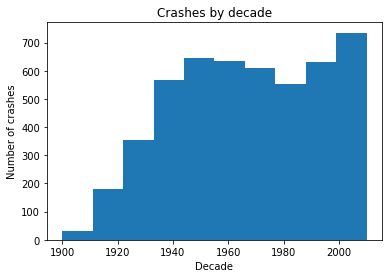

In [13]:
plt.hist(df['Decade'])
plt.title('Crashes by decade')
plt.xlabel('Decade')
plt.ylabel('Number of crashes')

Гипотеза: количество аварий воздушных суден. растет в связи с ростом количества полетов. 

Необходимо. добавить данные по всем полетам(не нашел датасет в открутом доступе) и вычислить (количество крушений) / (количество полетов) по десятелетиям. 

In [14]:
fat_per_decade = df.groupby(['Decade']).mean()['Fatalities']
aboard_per_decade = df.groupby(['Decade']).mean()['Aboard']
rate = fat_per_decade / aboard_per_decade

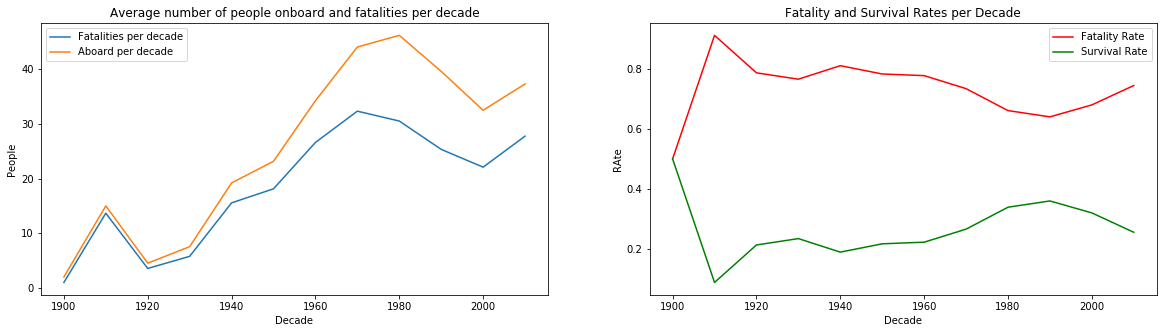

In [15]:
fig, ax = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)
ax[0].plot(fat_per_decade, label='Fatalities per decade')
ax[0].plot(aboard_per_decade, label='Aboard per decade')
#ax.plot(fat_per_decade/aboard_per_decade, label='Fatality Rate', color='r')
ax[0].set_title('Average number of people onboard and fatalities per decade')
ax[0].set_xlabel('Decade')
ax[0].set_ylabel('People')

ax[1].plot(fat_per_decade/aboard_per_decade, label='Fatality Rate', color='r')
ax[1].plot(1 - (fat_per_decade/aboard_per_decade), label='Survival Rate', color='g')
ax[1].set_title('Fatality and Survival Rates per Decade')
ax[1].set_xlabel('Decade')
ax[1].set_ylabel('RAte')

#secaxy = ax.secondary_yaxis('right')
ax[0].legend()
ax[1].legend()
plt.show()

Гипотеза: больший процент людей стал выживать

## #2

Интересно было посмотреть датасет, в котором рассмотрены факторы счастья в странах. 

https://www.kaggle.com/unsdsn/world-happiness?select=2019.csv

In [263]:
csv = pd.read_csv('datasets-894-813759-2019.csv')
df = pd.DataFrame(csv)

In [265]:
# Проверим, какие колонки слишком захламлены None
df.isnull().sum()/len(df)

Overall rank                    0.0
Country or region               0.0
Score                           0.0
GDP per capita                  0.0
Social support                  0.0
Healthy life expectancy         0.0
Freedom to make life choices    0.0
Generosity                      0.0
Perceptions of corruption       0.0
dtype: float64

In [266]:
# Удалим страну
(df == 0).astype(int).sum(axis=0)

Overall rank                    0
Country or region               0
Score                           0
GDP per capita                  1
Social support                  1
Healthy life expectancy         1
Freedom to make life choices    1
Generosity                      1
Perceptions of corruption       1
dtype: int64

In [243]:
df = df[(df != 0).all(1)]

In [244]:
(df == 0).astype(int).sum(axis=0)

Overall rank                    0
Country or region               0
Score                           0
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
dtype: int64

In [268]:
df

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298
...,...,...,...,...,...,...,...,...,...
151,152,Rwanda,3.334,0.359,0.711,0.614,0.555,0.217,0.411
152,153,Tanzania,3.231,0.476,0.885,0.499,0.417,0.276,0.147
153,154,Afghanistan,3.203,0.350,0.517,0.361,0.000,0.158,0.025
154,155,Central African Republic,3.083,0.026,0.000,0.105,0.225,0.235,0.035


In [278]:
np.random.seed(42)
X = df.iloc()[:, 3:]
y = df['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [279]:
X_train

,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
86,1.052,1.538,0.657,0.394,0.244,0.028
11,1.034,1.441,0.963,0.558,0.144,0.093
60,0.776,1.209,0.706,0.511,0.137,0.064
67,1.183,1.452,0.726,0.334,0.082,0.031
124,0.562,0.928,0.723,0.527,0.166,0.143
...,...,...,...,...,...,...
71,1.044,1.303,0.673,0.416,0.133,0.152
106,0.947,0.848,0.874,0.383,0.178,0.027
14,1.333,1.538,0.996,0.450,0.348,0.278
92,1.029,1.125,0.893,0.521,0.058,0.100


In [288]:
np.random.seed(42)
rgr = RandomForestRegressor()
rgr.fit(X_train, y_train)
rgr_pred = rgr.predict(X_test)
mean_squared_error(rgr_pred, y_test)

0.3443202808319147

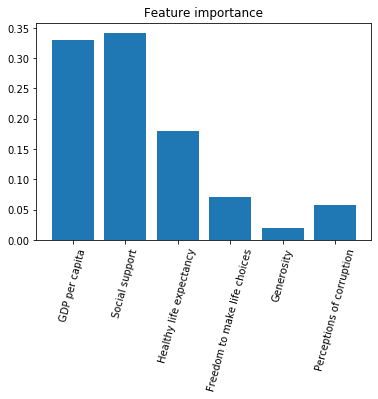

In [304]:
# Наиболее важные фичи
fi = rgr.feature_importances_

plt.figure()
plt.title("Feature importance")
plt.bar(range(1, len(fi)+1), fi)
plt.xticks(range(1, len(fi)+1), X_train.columns.tolist(), rotation=75)
plt.show()